<a href="https://colab.research.google.com/github/toluwee/Rheology_prediction_with_blending_ensemble/blob/main/Rheology_prediction_with_blending_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

 

*   Predict the apparent viscosity of nanoparticle stabilized CO2 foam fracturing fluid using blending (a stacking variant) machine learning ensemble model.
*   Determine the influence of various parameters on apparent viscosity prediction.



# About The Dataset
45 input data points were compiled from the published results of Fu and Liu's (2021) laboratory rheology experiments on nanoparticle-stabilized CO2-foam at high temperatures and pressure. 

The authors varied the temperature, concentration of nanoparticles, salinity, quality of foam, and the shear rate at constant backpressure of 1,300 psi. These variables served as input features for this analysis to predict the apparent viscosity of NP-CO2-foam when used as fracturing fluid. 

217 additional data records were generated from the collected dataset by polynomial interpolation to make a total of 262 records. 


The following is a description of the dataset.
					
**Attribute Information:**

| Position | Feature | Description |Feature Type |
|------:|:-----|---------|---------|
|[, 1]|	temp	|Temperature, centigrade|Numerical|
|[, 2]|	np_conc|	Nanoparticle conc., %wt |Numerical|
|[, 3]|	salinity|	Salinity, %wt |Numerical|
|[, 4]|	foam_qual|	Foam quality, %|Categorical|
|[, 5]|	shear|	Shear rate, s-1 |Numerical|
|[, 6]|	app_vis|	Apparent viscosity, cp|Numerical|


### Load Dataset

In [ ]:
import pandas as pd

filepath = 'https://datasciencefiles.s3.us-east-2.amazonaws.com/AppVis_Fu2.csv'

dataset = pd.read_csv(filepath)

# Descriptive Statistics

In [ ]:
# shape
dataset.shape

(262, 6)

In [ ]:
dataset.sample(n=5, replace = False)

,temp,np_conc,salinity,foam_qual,shear,app_vis
180,20,0.50,0.07,0.70,3027,21.15
31,20,0.50,0.05,0.11,3027,8.29
169,20,0.64,0.05,0.70,3027,16.10
134,20,0.29,0.05,0.70,3027,15.35
228,39,0.50,0.05,0.70,4400,8.29


In [ ]:
pd.set_option('precision', 2)
dataset.agg(['mean','min', 'max', 'std'])

,temp,np_conc,salinity,foam_qual,shear,app_vis
mean,25.26,0.47,5.07e-02,0.60,3227.09,12.08
min,20.00,0.05,3.00e-02,0.10,1338.00,2.63
max,72.00,0.70,1.10e-01,0.90,4400.00,34.54
std,12.53,0.11,6.03e-03,0.21,723.86,5.38


# Create Test Dataset

In [ ]:
# Seperate output and input variables
target = ["app_vis"]
X_full,y_full = dataset.drop(target, axis=1), dataset[target]

In [ ]:
from sklearn.model_selection import train_test_split
# seperate training and test data 
train_X, test_X, y_train, y_test = train_test_split(X_full,y_full, test_size=0.2,random_state=42)


# Preprocessing


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(train_X)
X_test = scaler.transform(test_X)

In [ ]:
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

# Base Models

In [ ]:
# Create function to build and compile a Keras neural network model
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop


def build_model(n_hidden=1, n_neurons=20, learning_rate = 3e-3, input_shape = X_train.shape[1:]): # explicitly state no of features as input_shape
  model = Sequential()
  options = {"input_shape": input_shape}

  for layer in range(n_hidden):
    model.add(Dense(n_neurons, activation="relu", 
                    **options))
    options ={} # so that input_shape option only applies to first layer
  model.add(Dense(1, activation="linear",  
                  **options)) #output layer

  optimizer = RMSprop(learning_rate)
  model.compile(loss = "mse", optimizer = optimizer) # mse represents l2 loss

  return model

In [ ]:
# Preprocess training and testing dataset to be suitable for polynomial regression

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [ ]:
# Create base models
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

model_SVR = SVR(C= 64, degree = 5, gamma= 0.28510676478015073, kernel= 'rbf')
model_MPR = LinearRegression()
model_ANN = build_model()
model_CART = DecisionTreeRegressor(random_state= 42) 
model_KNN = KNeighborsRegressor(algorithm = 'auto', leaf_size = 98, n_neighbors = 3, p = 1)

# Blending

In [ ]:
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from numpy import hstack

# get a list of base models
def get_models():
	models = []

	models.append(('SVR', model_SVR))
	models.append(('MPR', model_MPR))
	models.append(('ANN', model_ANN))
	models.append(('CART', model_CART))
	models.append(('KNN', model_KNN))
	return models

# fit the blending ensemble
def fit_ensemble(models, X_train, X_test, y_train, y_test):
	# fit all models on the training set and predict on hold out set
	meta_X = list()
 
	for name,model in models:
		if name == 'MPR':
			# fit in training set
			X_train_poly1 = PolynomialFeatures(degree=4).fit_transform(X_train)
			model.fit(X_train_poly1, y_train)
		elif name == 'ANN':
			model.fit(X_train, y_train, epochs = 300, batch_size = 20, 
         validation_split = 0.2,callbacks=[keras.callbacks.EarlyStopping(patience=10)])
		else:
			# fit in training set
			model.fit(X_train, y_train)	 
	
	# predict on test set

	for name,model in models:
		if name == 'MPR':
			X_poly= PolynomialFeatures(degree=4).fit_transform(X_test)
			yhat = model.predict(X_poly) 
		else:
			yhat = model.predict(X_test)
		
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store predictions as input for blending
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# define blending model
 
	blender = SVR(C= 83, gamma= 0.15996237372700434, kernel= 'rbf')

	# fit on predictions from base models
	blender.fit(meta_X, y_test)
	return blender

# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
	# make predictions with base models
	meta_X = list()
	for name ,model in models:
		# predict with base model
		if name == 'MPR':
			X_poly= PolynomialFeatures(degree=4).fit_transform(X_test)
			yhat = model.predict(X_poly)
		else:
			yhat = model.predict(X_test)

		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store prediction
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# predict
	return blender.predict(meta_X)

# create the base models
models = get_models()

# train the blending ensemble


blender = fit_ensemble(models, X_train, X_train, y_train, y_train)

blender_2 = fit_ensemble(models, X_train, X_test, y_train, y_test)

Blended_pred_train = predict_ensemble(models, blender, X_train)

Blended_pred = predict_ensemble(models, blender_2, X_test)



Epoch 1/300
9/9 [==============================] - 1s 22ms/step - loss: 178.1446 - val_loss: 163.1702
Epoch 2/300
9/9 [==============================] - 0s 5ms/step - loss: 168.6161 - val_loss: 156.8229
Epoch 3/300
9/9 [==============================] - 0s 8ms/step - loss: 161.3877 - val_loss: 150.9731
Epoch 4/300
9/9 [==============================] - 0s 8ms/step - loss: 154.4703 - val_loss: 144.9588
Epoch 5/300
9/9 [==============================] - 0s 5ms/step - loss: 147.3988 - val_loss: 138.7167
Epoch 6/300
9/9 [==============================] - 0s 5ms/step - loss: 140.2091 - val_loss: 132.6962
Epoch 7/300
9/9 [==============================] - 0s 6ms/step - loss: 133.1612 - val_loss: 126.3015
Epoch 8/300
9/9 [==============================] - 0s 4ms/step - loss: 125.9559 - val_loss: 120.1234
Epoch 9/300
9/9 [==============================] - 0s 5ms/step - loss: 119.0943 - val_loss: 114.0213
Epoch 10/300
9/9 [==============================] - 0s 7ms/step - loss: 112.1257 - val_los

**Note**: Results will vary given the stochastic nature of the neural network algorithm. Running the example a few times and comparing the average outcome gives the reported RMSE for the Blending technique.

## Plot Predicted vs Measured

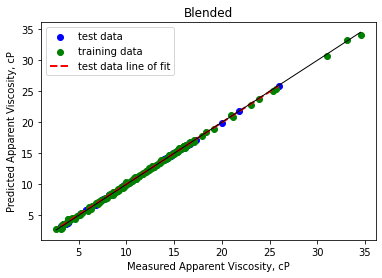

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Plot predicted vs Measured for Apparent Viscosity

predicted = Blended_pred_train
predicted2 = Blended_pred

fig, ax = plt.subplots()
ax.scatter(y_test, predicted2 , c='blue', label ='test data ')
ax.scatter(y_train, predicted, c= 'green', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1))(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('Blended')
ax.set_xlabel('Measured Apparent Viscosity, cP')
ax.set_ylabel('Predicted Apparent Viscosity, cP')

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()
# patch = mpatches.Patch(color='grey', label='manual patch')   
line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
# handles.extend([patch, line])
handles.extend([line])

plt.legend(handles=handles)

plt.show()

# Evaluations

## On Training Dataset 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

rmse = round(np.abs(mean_squared_error(y_train, Blended_pred_train, squared=False)), 3 )
mae = round(np.abs(mean_absolute_error(y_train, Blended_pred_train)), 3 )
r_squared = round(r2_score(y_train, Blended_pred_train), 3 )

print("RMSE on training data: ", rmse)
print("MAE on training data: ", mae)
print("R-squared on training data: ", r_squared)

RMSE on training data:  0.148
MAE on training data:  0.112
R-squared on training data:  0.999


## On Testing Dataset 

In [ ]:
rmse = round(np.abs(mean_squared_error(y_test, Blended_pred, squared=False)), 3 )
mae = round(np.abs(mean_absolute_error(y_test, Blended_pred)), 3 )
r_squared = round(r2_score(y_test, Blended_pred), 3 )

print("RMSE on testing data: ", rmse)
print("MAE on testing data: ", mae)
print("R-squared on testing data: ", r_squared)

RMSE on testing data:  0.094
MAE on testing data:  0.091
R-squared on testing data:  1.0


# PCA Implementation

In [ ]:
from sklearn.decomposition import PCA
# Create a PCA instance: pca
pca = PCA(n_components=5
          )
df_trans= pca.fit_transform(X_train)

print("original shape:   ", X_train.shape)
print("transformed shape:", df_trans.shape)

original shape:    (209, 5)
transformed shape: (209, 5)


In [ ]:
import numpy as np
#Assign labels to components
components = pca.components_.T * np.sqrt(pca.explained_variance_)

Compo = pd.concat([pd.DataFrame(train_X.columns), pd.DataFrame(components)], axis=1)


Compo.columns = ['Features','Principal Component 1', 'Principal Component 2',
                               'Principal Component 3',
                 'Principal Component 4',
                                'Principal Component 5',
                 
                               ]
to_be_changed = ['Principal Component 1', 'Principal Component 2',
                               'Principal Component 3',
                 'Principal Component 4',
                                'Principal Component 5',
]

for value in to_be_changed:
  Compo[value] = Compo[value].abs() 


In [ ]:
from google.colab import data_table
data_table.DataTable(Compo, include_index=False)

,Features,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5
0,temp,0.89,0.13,0.04,0.19,3.94e-01
1,np_conc,0.14,0.82,0.30,0.47,2.00e-02
2,salinity,0.06,0.14,0.96,0.26,9.63e-03
3,foam_qual,0.45,0.65,0.15,0.60,1.50e-02
4,shear,0.90,0.06,0.02,0.20,3.95e-01


# Feature Importance

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


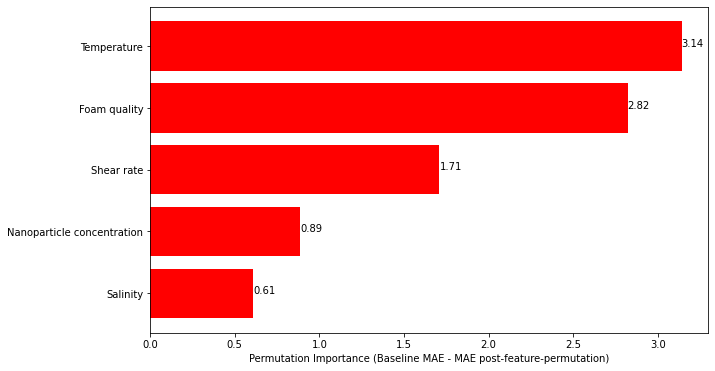

In [ ]:
from sklearn.inspection import permutation_importance
# perform permutation importance
results = permutation_importance(model_SVR, X_train, y_train,
                                 scoring='neg_mean_absolute_error',
                                 n_repeats=10, n_jobs=-1, random_state=42)
# get importance
feature_importance = results.importances_mean

train_X.rename(columns = {'temp': 'Temperature',
                          'foam_qual': 'Foam quality',
                          'shear':'Shear rate',
                          'np_conc': 'Nanoparticle concentration',
                          'salinity': 'Salinity'}, inplace= True)

sorted_feat= sorted(zip(feature_importance, train_X), reverse=False)

# Create two lists from the list of tuples created
value,name = [list(c) for c in zip(*sorted_feat)]

# Plot the features
plt.figure(figsize=(10,6))
plt.barh(y = name, width= value, color= 'r')

for index, value in enumerate(value):
  value = round(value,2)
  plt.text(value, index, str(value))

plt.xlabel('Permutation Importance (Baseline MAE - MAE post-feature-permutation)')
# plt.ylabel(' Features ')
plt.show()

